# Setup

In [ ]:
import os, sys, random, torch, numpy as np

os.chdir("..")
print("CWD:", os.getcwd())
sys.path.append(os.path.abspath("src"))

In [2]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

# Data Preparation

In [ ]:
#!pip install kagglehub --quiet

import kagglehub
import tarfile
import os

path = kagglehub.dataset_download("atulanandjha/lfwpeople")
print("Downloaded files:", os.listdir(path))

extract_path = "./data/lfw-funneled"
os.makedirs(extract_path, exist_ok=True)

tar_path = os.path.join(path, "lfw-funneled.tgz")
with tarfile.open(tar_path, "r:gz") as tar:
    tar.extractall(path=extract_path)

print("Extraction done! Files in dataset folder:", os.listdir(extract_path))

Using Colab cache for faster access to the 'lfwpeople' dataset.
Downloaded files: ['pairsDevTrain.txt', 'lfw-funneled.tgz', 'pairsDevTest.txt', 'pairs.txt']


/tmp/ipython-input-753395924.py:15: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_path)


Extraction done! Files in dataset folder: ['lfw_funneled']


In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((160,160)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(extract_path, transform=transform)

train_idx, val_idx = train_test_split(range(len(dataset)), test_size=0.2, random_state=SEED, shuffle=True)
train_dataset = Subset(dataset, train_idx)
val_dataset   = Subset(dataset, val_idx)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)} | Validation samples: {len(val_dataset)}")

Train samples: 10586 | Validation samples: 2647


# Model Definition

In [5]:
import torch
import torch.nn as nn

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class ResidualSEBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(channels), nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(channels), SEBlock(channels)
        )

    def forward(self, x):
        return nn.functional.relu(x + self.block(x))

class Autoencoder(nn.Module):
    def __init__(self, bn_chan=25):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(32), nn.ReLU(True), ResidualSEBlock(32),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(64), nn.ReLU(True), ResidualSEBlock(64),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(128), nn.ReLU(True), ResidualSEBlock(128),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(256), nn.ReLU(True), ResidualSEBlock(256),
            nn.Conv2d(256, bn_chan, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(bn_chan), nn.ReLU(True), ResidualSEBlock(bn_chan)
        )
        self.decoder = nn.Sequential(
            ResidualSEBlock(bn_chan), nn.ConvTranspose2d(bn_chan, 256, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(256), nn.ReLU(True),
            ResidualSEBlock(256), nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(128), nn.ReLU(True),
            ResidualSEBlock(128), nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(64), nn.ReLU(True),
            ResidualSEBlock(64), nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(32), nn.ReLU(True),
            ResidualSEBlock(32), nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Testing and Results

In [ ]:
#!pip install pytorch_msssim --quiet
from src.train_autoencoder import train_autoencoder
from src.return_ssim import return_ssim
from src.retrieve_imgs import retrieve_imgs
from src.plt_imgs import plt_imgs

In [7]:
import torch
import torch.nn as nn
from pytorch_msssim import SSIM

mse_loss = nn.MSELoss()
ssim_loss = SSIM(data_range=1.0, size_average=True, channel=3).to(DEVICE)

def hybrid_loss(outputs, targets, alpha=0.3):
    return alpha * mse_loss(outputs, targets) + (1-alpha) * (1-ssim_loss(outputs, targets))

In [ ]:
import torch.optim as optim
bn_channels = 81
save_dir="models"

model = Autoencoder(bn_chan = bn_channels).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

#model.load_state_dict(torch.load(f"{save_dir}/RAE_{bn_channels}.pt", map_location=DEVICE)) # load model

<All keys matched successfully>

In [ ]:
train_autoencoder(
    model=model,
    train_loader=train_loader,
    test_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=hybrid_loss,
    DEVICE=DEVICE,
    num_epochs=100,
    model_name=f"RAE_{bn_channels}",
    #save_dir=save_dir, #uncomment if you want to save the model as a .pt file
    patience=4
)

Epoch [1/100], Loss: 0.4686, SSIM: 0.4545
Epoch [2/100], Loss: 0.2932, SSIM: 0.6598
Epoch [3/100], Loss: 0.2104, SSIM: 0.6186
Epoch [4/100], Loss: 0.1740, SSIM: 0.7656
Epoch [5/100], Loss: 0.1481, SSIM: 0.7988
Epoch [6/100], Loss: 0.1272, SSIM: 0.8264
Epoch [7/100], Loss: 0.1150, SSIM: 0.8421
Epoch [8/100], Loss: 0.1046, SSIM: 0.4960
Epoch [9/100], Loss: 0.1011, SSIM: 0.8441
Epoch [10/100], Loss: 0.0936, SSIM: 0.8694
Epoch [11/100], Loss: 0.0886, SSIM: 0.8674
Epoch [12/100], Loss: 0.0848, SSIM: 0.8763
Epoch [13/100], Loss: 0.0843, SSIM: 0.8710
Epoch [14/100], Loss: 0.0808, SSIM: 0.8593
Epoch [15/100], Loss: 0.0812, SSIM: 0.8797
Epoch [16/100], Loss: 0.0773, SSIM: 0.8864
Epoch [17/100], Loss: 0.0753, SSIM: 0.8848
Epoch [18/100], Loss: 0.0739, SSIM: 0.8848
Epoch [19/100], Loss: 0.0744, SSIM: 0.8848
Epoch [20/100], Loss: 0.0739, SSIM: 0.8820
Early stopping at epoch 20, best SSIM: 0.8864
Training time: 905.39s


In [9]:
ssim_score = return_ssim(model, val_loader, DEVICE=DEVICE)

print(f"Final SSIM score: {ssim_score:.4f}")

Final SSIM score: 0.8864


In [13]:
#NOTICE = we train the model on train_loader, then pass test_loader images as the input image, then retrieve images from the train_loader
test_imgs, _ = next(iter(val_loader))
input_indices = [0, 1, 2]

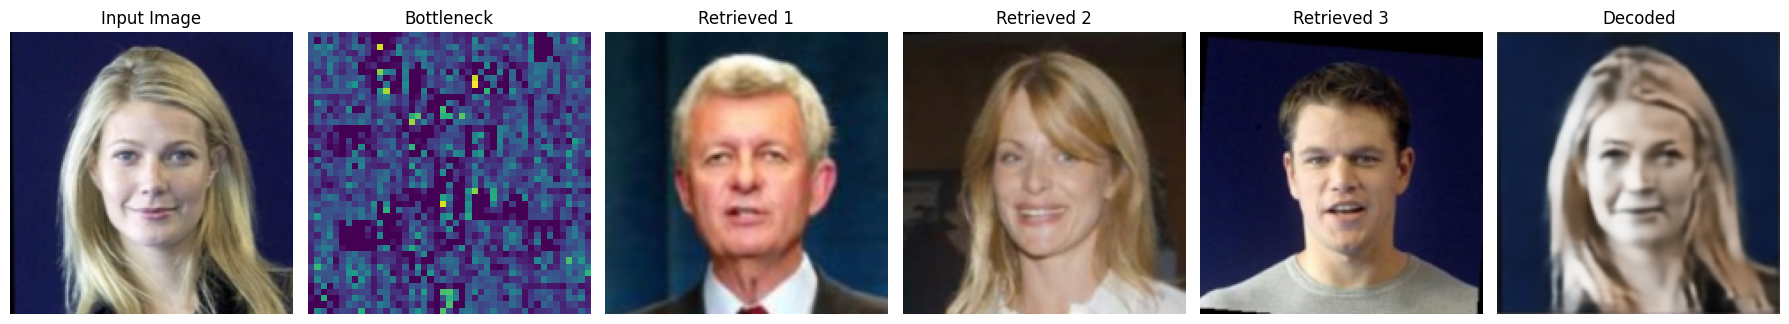

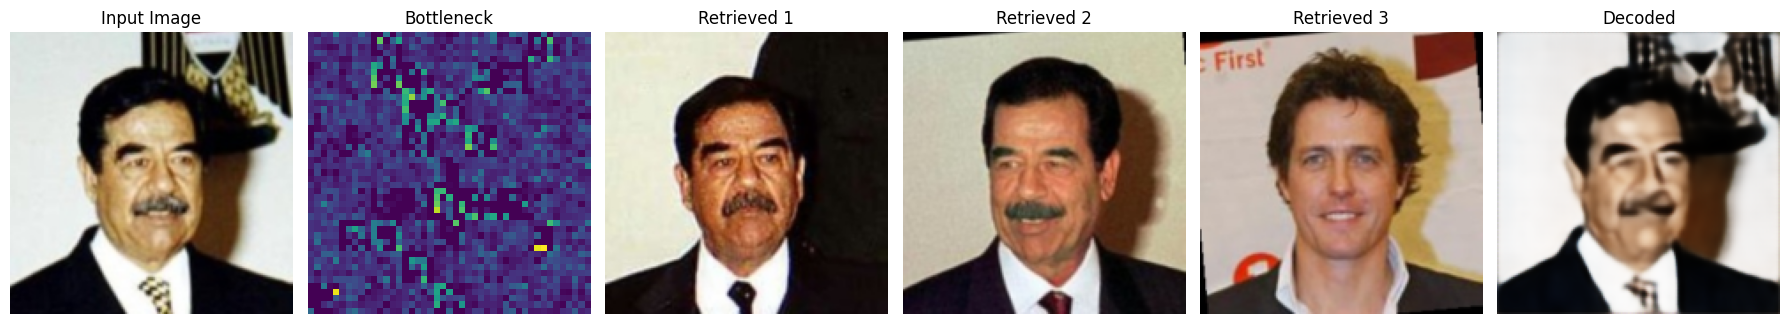

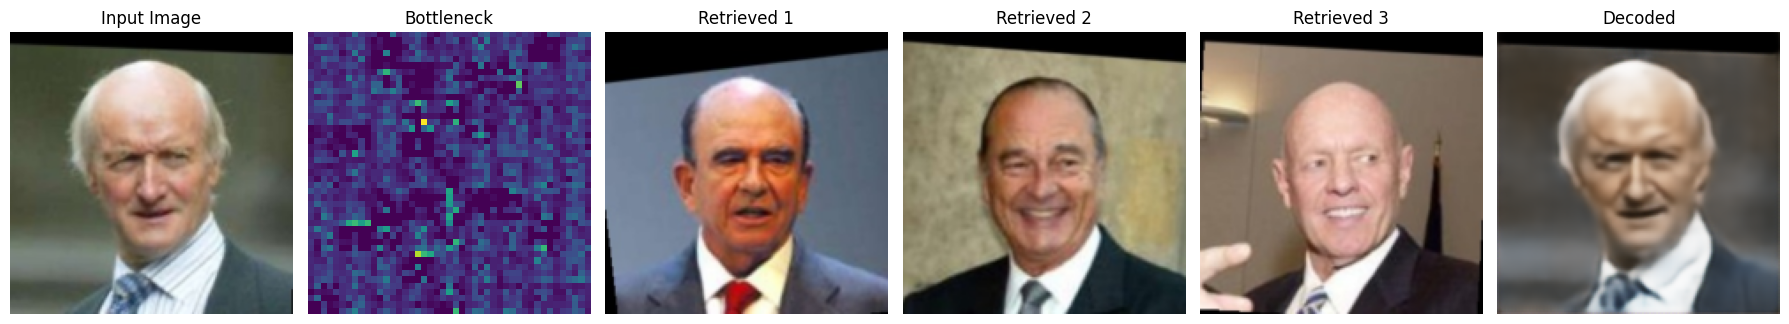

In [14]:
retrieved_results = []

for idx in input_indices:
    input_img = test_imgs[idx]
    in_img, bottleneck, top_imgs, decoded_bn = retrieve_imgs(model, input_img, train_loader, DEVICE)
    retrieved_results.append((in_img, bottleneck, top_imgs, decoded_bn))

for in_img, bottleneck, top_imgs, decoded_bn in retrieved_results:
    plt_imgs(in_img, bottleneck, top_imgs, decoded_bn)